In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
from templates import *

### Load model

In [15]:
device = 'cuda:0'
conf = font32_autoenc_10K()
conf.use_condition = False
# print(conf.name)
model = LitModel(conf)
state = torch.load(f'/home/devesh_temp/scratch/diffae_hpc/diffae/checkpoints/font128_autoenc_trained_style/last.ckpt', map_location='cpu')
model.load_state_dict(state['state_dict'], strict=False)
model.ema_model.eval()
model.ema_model.to(device);

Global seed set to 0


Model params: 120.90 M


### Load Image pair to interpolate

In [16]:
data = ImageDataset('./run_on_these', image_size=(64,64), exts=['jpg', 'JPG', 'png'], do_augment=False)
batch = torch.stack([
    data[0]['img'],
    data[1]['img'],
])

In [17]:
temp = batch[0].clone()
batch[0] = batch[1].clone()
batch[1] = temp

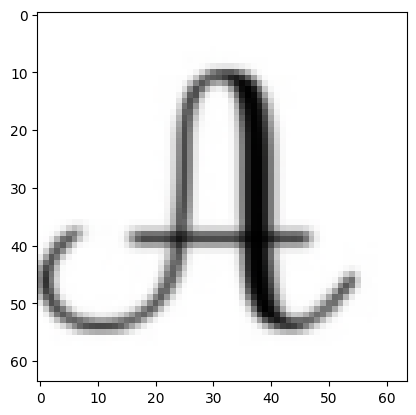

In [18]:
import matplotlib.pyplot as plt
plt.imshow(batch[0].permute([1, 2, 0]) / 2 + 0.5)

### Get Latent and Stochastic code

In [19]:
cond = model.encode(batch.to(device), [0,4], ['WRESLING', 'WRESLING'])
cond =  cond 
alpha = 0.5
rand = torch.randn_like(cond)
# cond = alpha * cond + (1-alpha) * cond

xT = model.encode_stochastic(batch.to(device), cond, T=100)
# instead of generating it here, sample from xT ∼ N (0, I)
alpha = 0.5
rand = torch.randn_like(xT)
# xT = alpha * rand + (1-alpha) * xT
print(cond.shape, xT.shape)

torch.Size([2, 512]) torch.Size([2, 3, 64, 64])


### Get Basis for the Stochastic Latent Space

In [20]:
import torchvision.utils as tvu
import torchvision.transforms as transforms 
import matplotlib.pyplot as plt

def x_space_guidance(xt, t_idx, vk, single_edit_step):
    
    print(xt.shape, vk.shape)
    # necesary parameters
    t = self.scheduler.timesteps[t_idx]

    # edit xt with vk
    xt_edit = xt + single_edit_step * vk

    # predict the noise residual
    et = self.unet(
        torch.cat([xt, xt_edit], dim=0), t, 
    )
    if not isinstance(et, torch.Tensor):
        et = et.sample

    # DDS regularization
    et_null, et_edit = et.chunk(2)
    xt_edit = xt + self.x_space_guidance_scale * (et_edit - et_null)
    return xt_edit



device = 'cuda:0'; dtype=torch.float32
# 1. get latent code
xT = model.encode_stochastic(batch.to(device), cond, T=100)
xT_0 = xT[0].unsqueeze(0); cond_0 = cond[0].unsqueeze(0)
xT_1 = xT[1].unsqueeze(0); cond_1 = cond[1].unsqueeze(0)


# 2. xT -> xt (get denoised image)
xt_0 = model.render(xT_0, cond_0, T=2)
xt_1 = model.render(xT_1, cond_1, T=2)
    
# get local basis
pca_rank = 50
assert pca_rank == 50
save_dir = f'./outputs/local_encoder_pullback_uncond-model/'
os.makedirs(save_dir, exist_ok=True)
u_0_path = os.path.join(save_dir, 'u_0' + '.pt')
u_1_path = os.path.join(save_dir, 'u-1' + '.pt')
vT_0_path = os.path.join(save_dir, 'vT-0' + '.pt')
vT_1_path = os.path.join(save_dir, 'vT-1' + '.pt')
xt_0 = xt_0.to(device=device, dtype=dtype)
t = torch.tensor([50] * 1, dtype=torch.float16, device='cuda')
u_0, s, vT_0 = model.ema_model.local_encoder_pullback_xt(xT_0, t, cond_0, pca_rank=50) # FIXME: changing xt_0 to xT_0
# save semantic direction in h-space
torch.save(u_0, u_0_path)
torch.save(vT_0, vT_0_path)
u_0 = u_0.to('cpu')
vT_0 = vT_0.to('cpu')

xt_1 = xt_1.to(device=device, dtype=dtype)
u_1, s, vT_1 = model.ema_model.local_encoder_pullback_xt(xT_1, t, cond_1, pca_rank=50)

# save semantic direction in h-space
torch.save(u_1, u_1_path)
torch.save(vT_1, vT_1_path)
u_1 = u_1.to('cpu')
vT_1 = vT_1.to('cpu')

# get latent code
original_xt_0 = model.render(xT_0, cond_0, T=10)
original_xt_1 = model.render(xT_1, cond_1, T=10)

# print(original_xt_0.shape, original_xt_1.shape)
# resize_transform = transforms.Resize((128, 256))
# pred = [resize_transform(image) for image in [original_xt_0, original_xt_1]]
# torch.manual_seed(1)
# fig, ax = plt.subplots(1, 2, figsize=(10*10, 20))
# for i in range(2):
#     ax[i].imshow(pred[i][0].permute(1, 2, 0).cpu())
# plt.savefig('compare.png')

single v jacfwd t == 3.878880262374878
power method : 0-th step convergence :  tensor(10.0235)
single v jacfwd t == 3.8488991260528564
power method : 1-th step convergence :  tensor(9.1164)
single v jacfwd t == 3.8417556285858154
power method : 2-th step convergence :  tensor(6.6106)
single v jacfwd t == 3.838927745819092
power method : 3-th step convergence :  tensor(4.0101)
single v jacfwd t == 3.815608024597168
power method : 4-th step convergence :  tensor(3.1898)
single v jacfwd t == 3.815171241760254
power method : 5-th step convergence :  tensor(3.0330)
single v jacfwd t == 3.8183586597442627
power method : 6-th step convergence :  tensor(0.9298)
single v jacfwd t == 3.8150737285614014
power method : 7-th step convergence :  tensor(0.5945)
single v jacfwd t == 3.815572738647461
power method : 8-th step convergence :  tensor(0.6419)
single v jacfwd t == 3.8072705268859863
power method : 9-th step convergence :  tensor(0.5896)
single v jacfwd t == 3.8115580081939697
power method :

/home/devesh_temp/.local/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


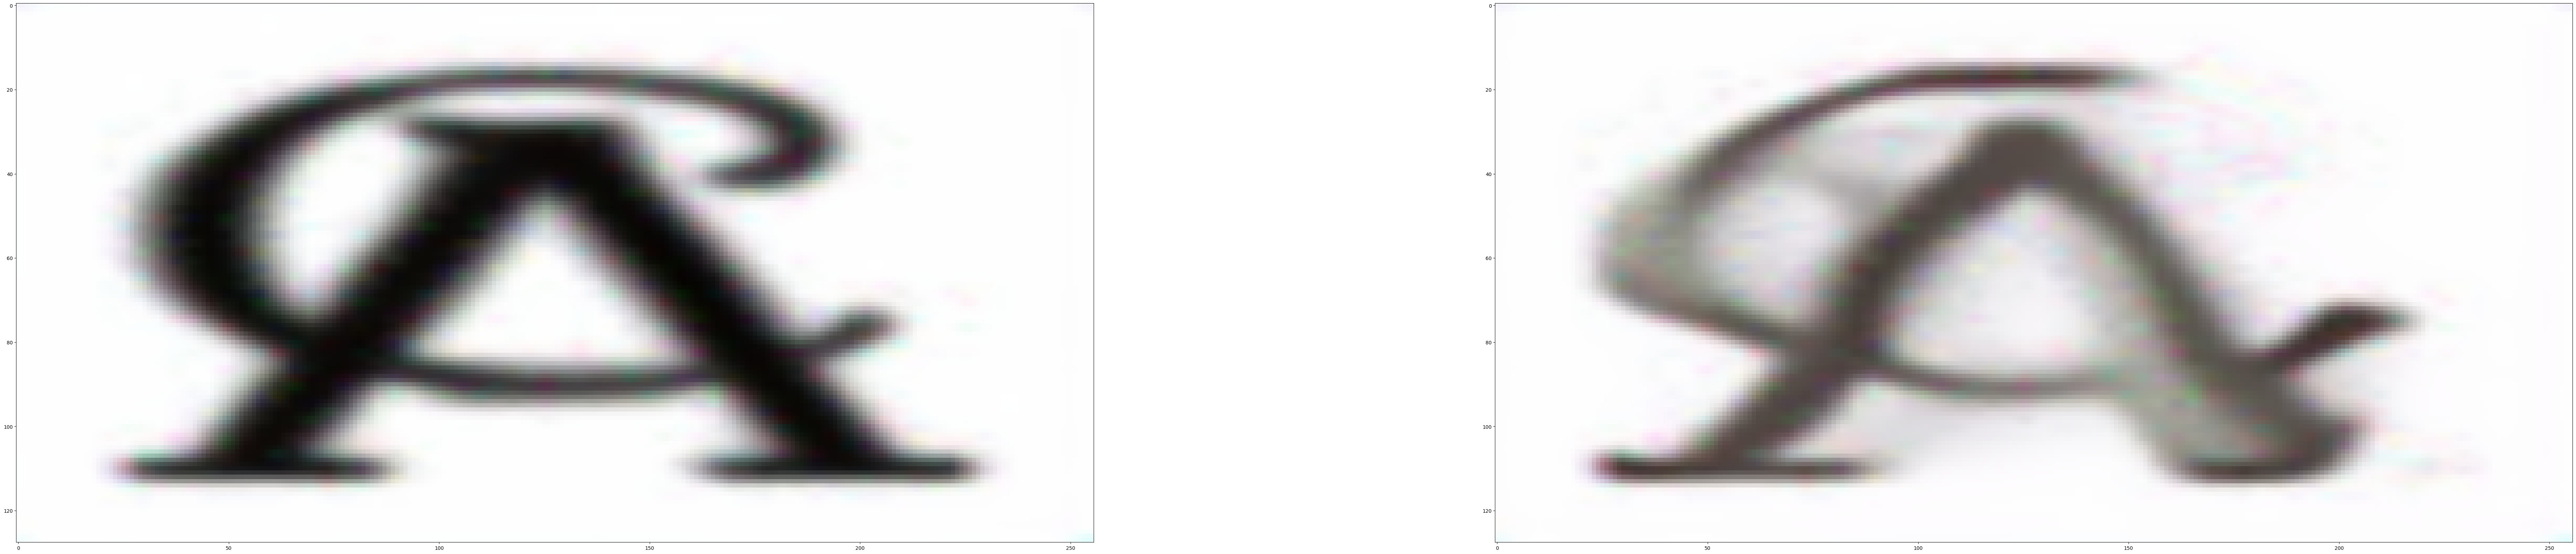

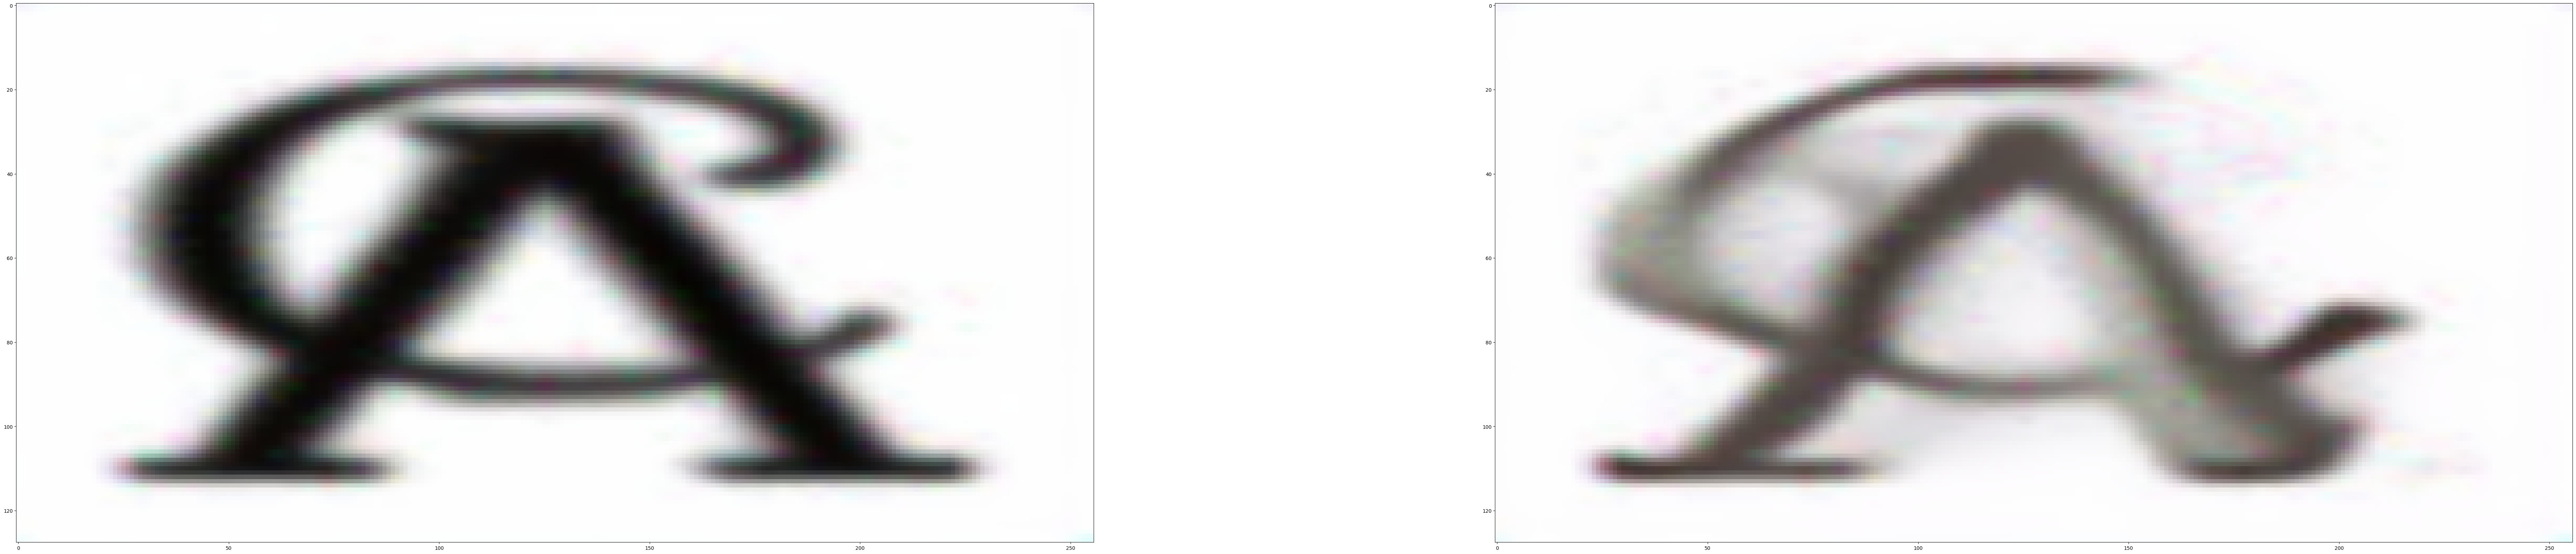

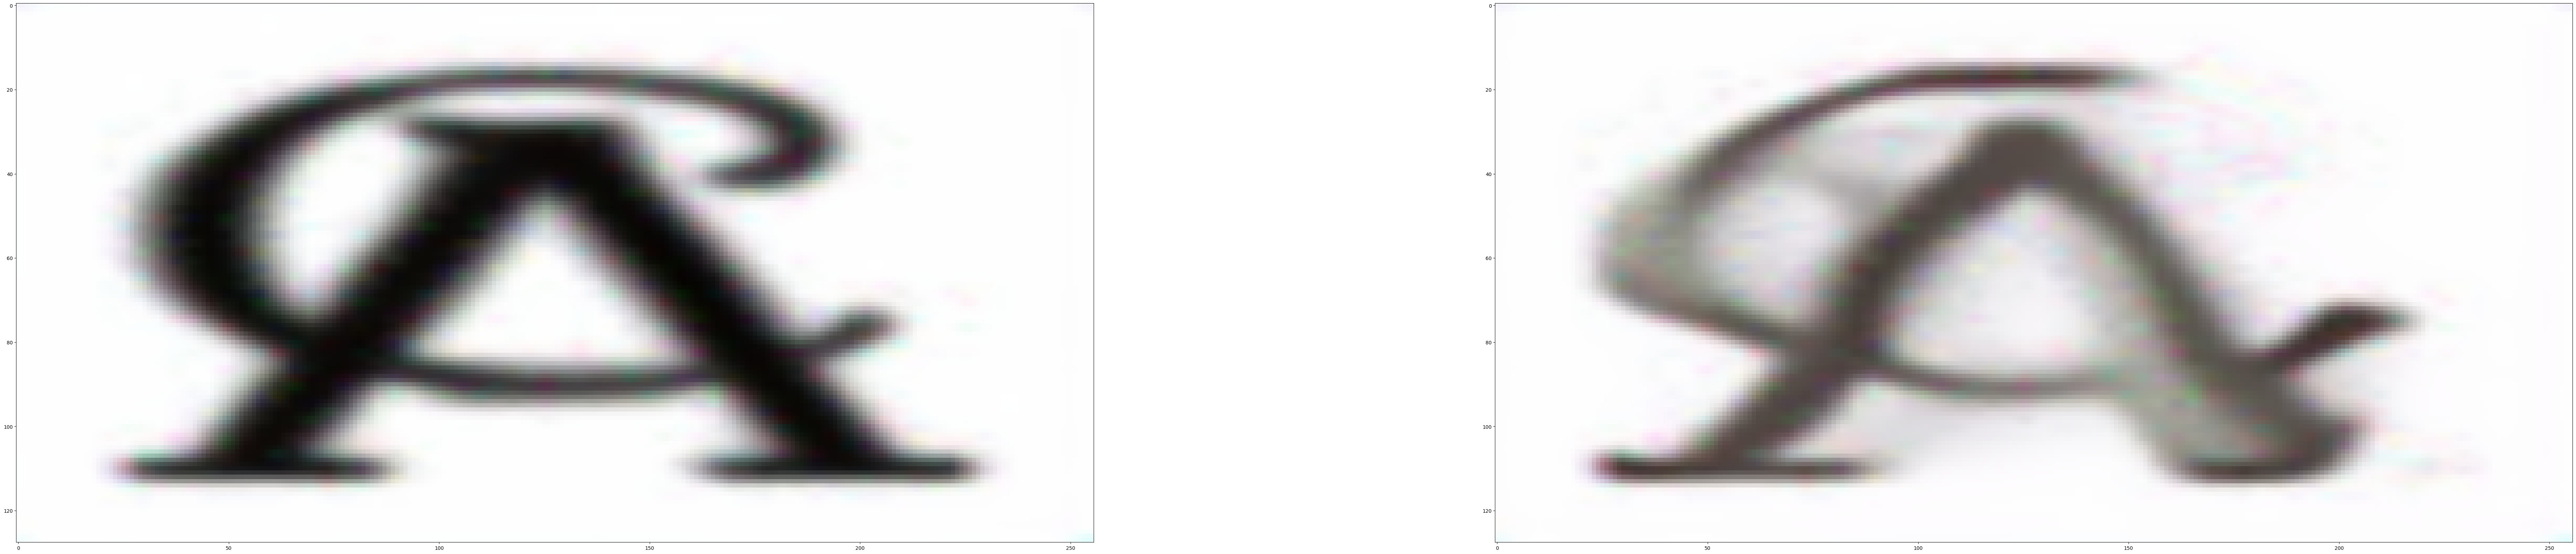

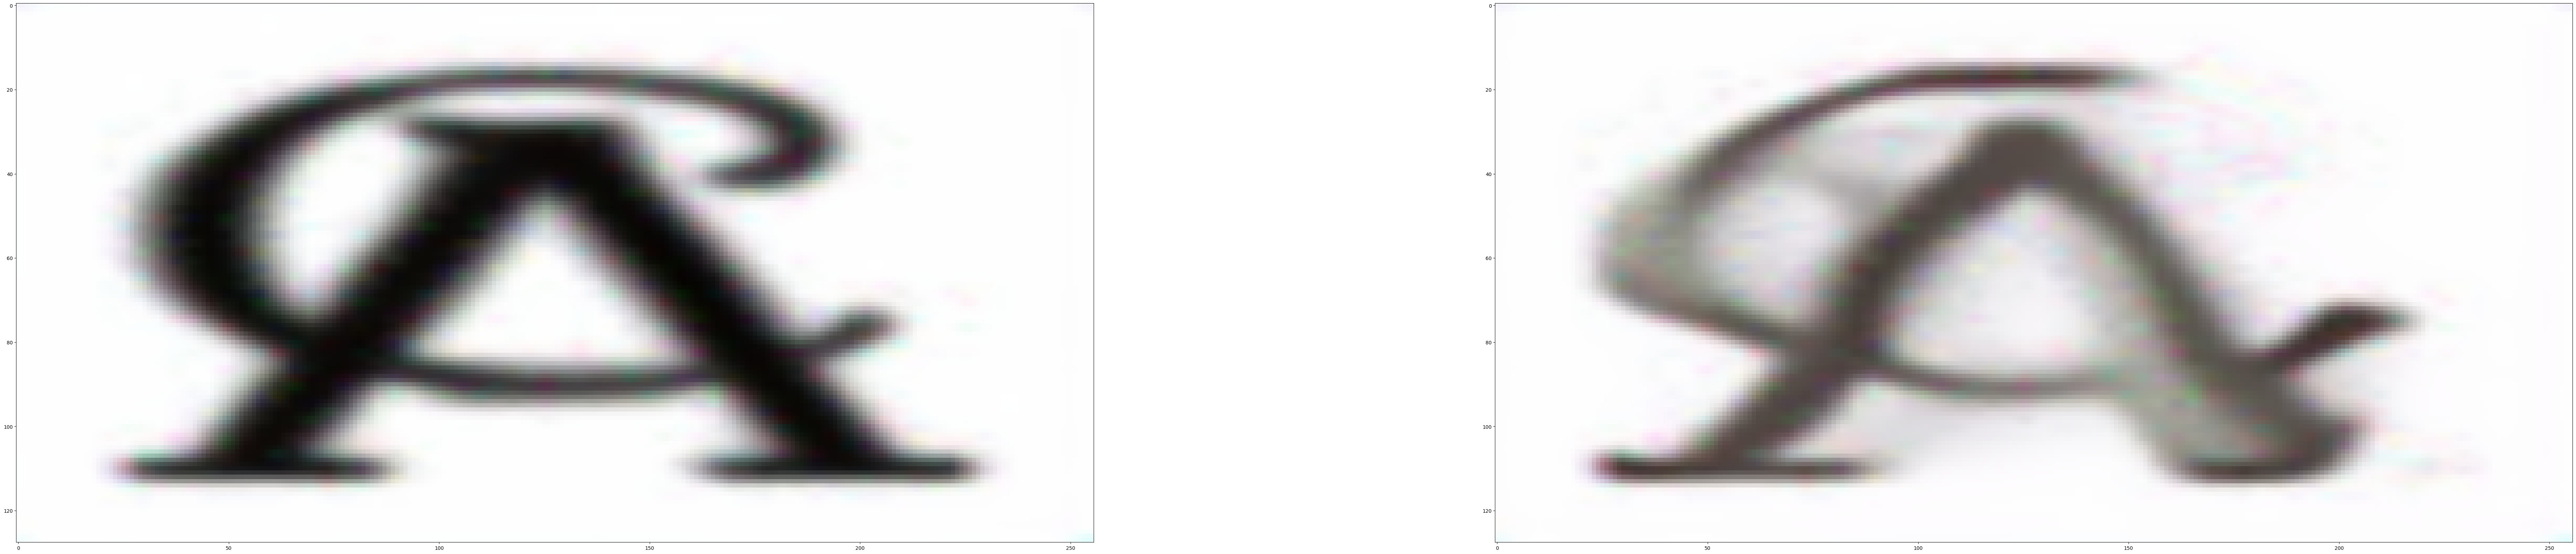

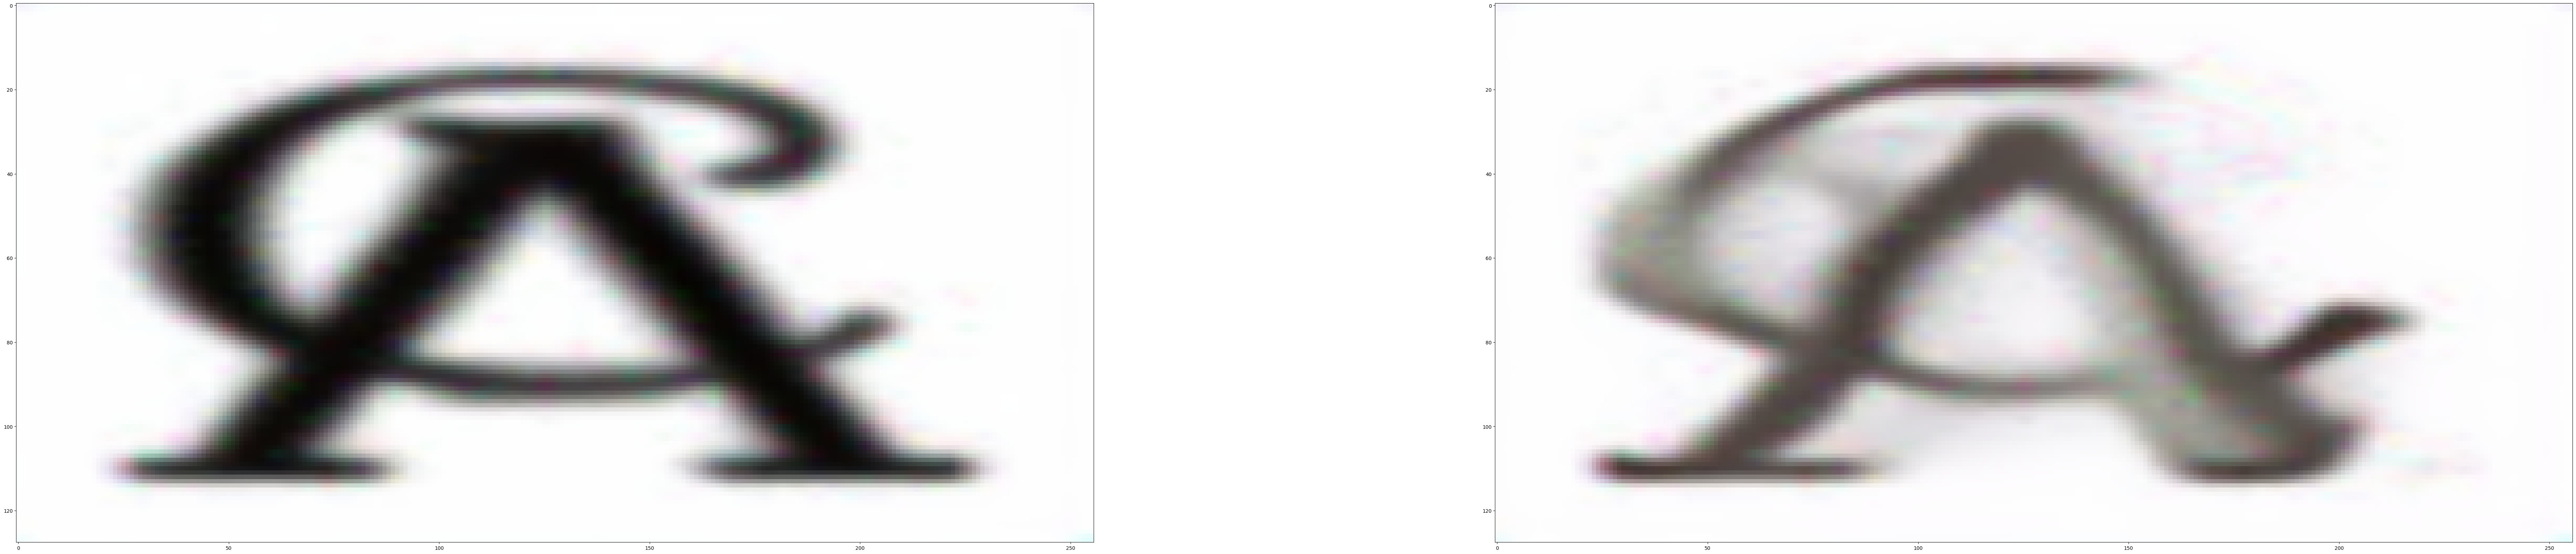

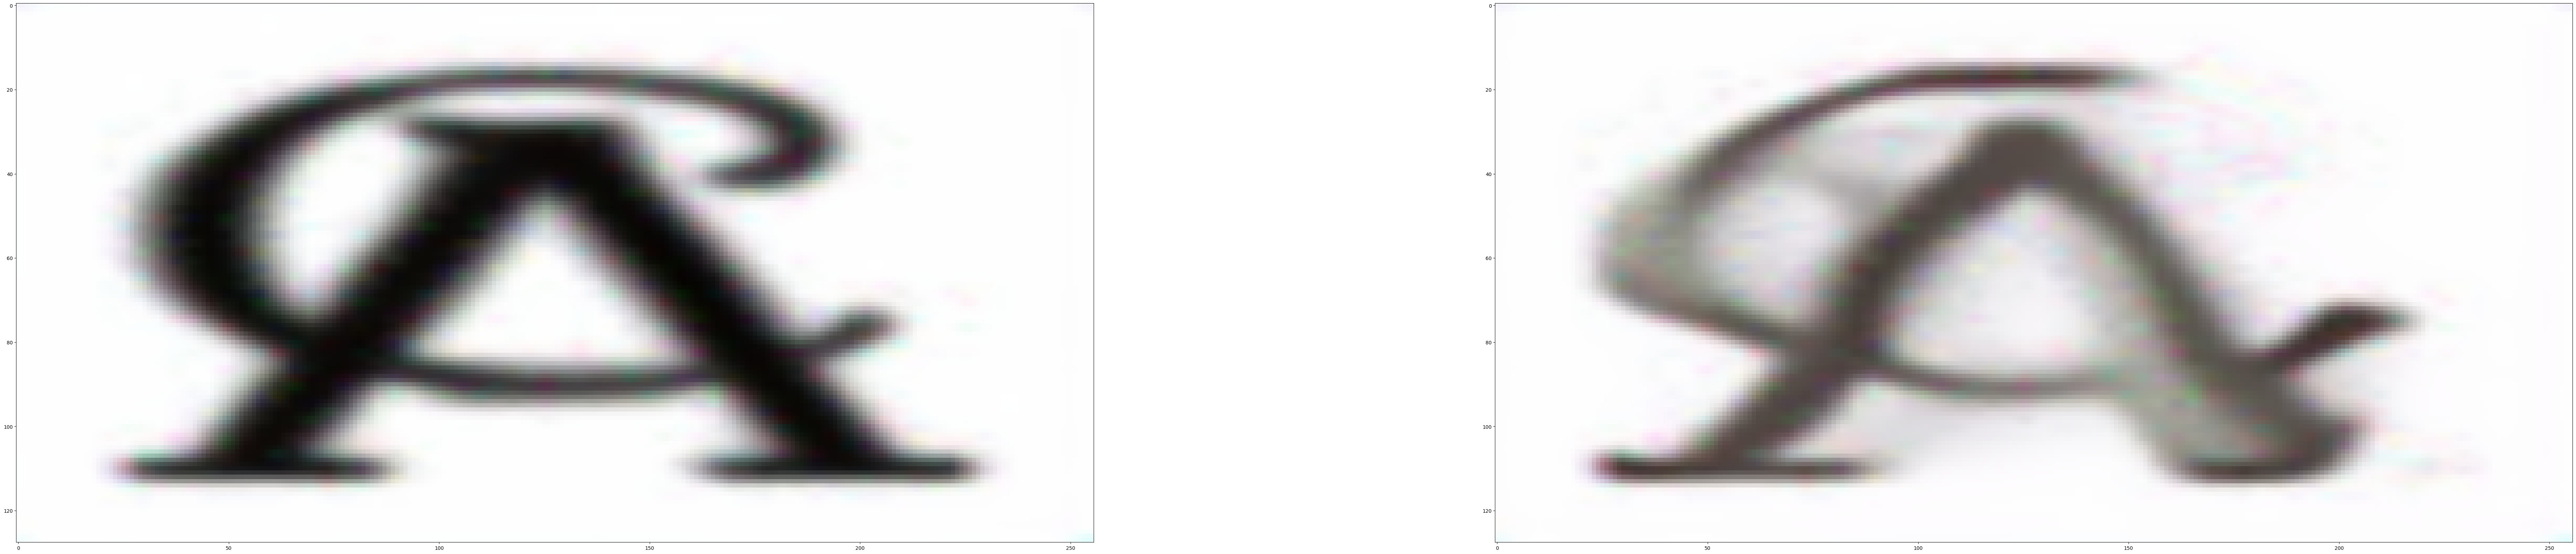

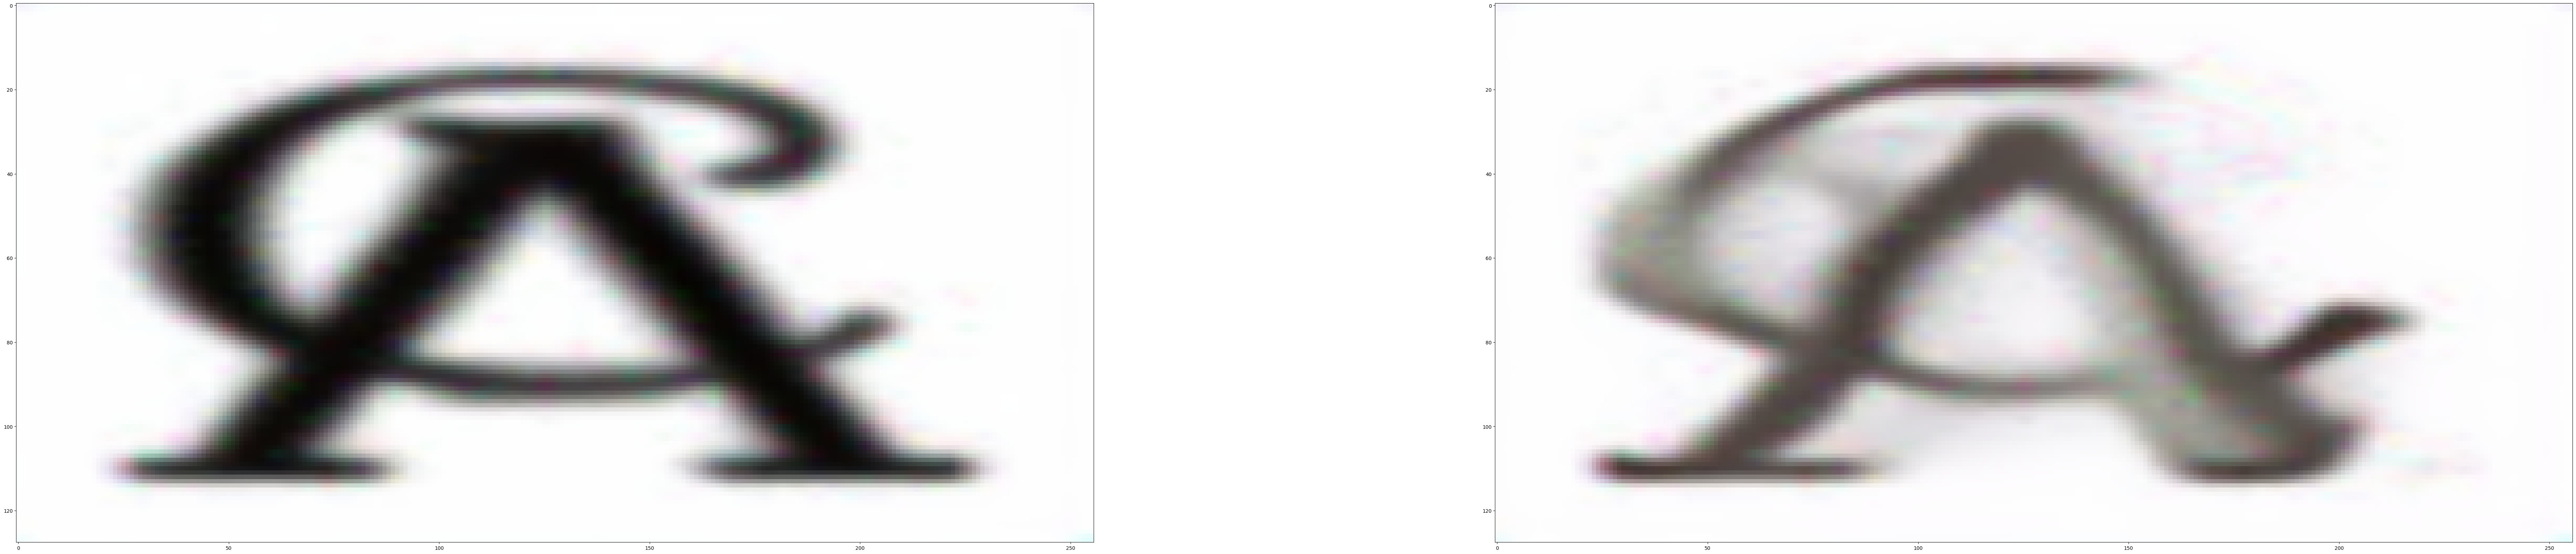

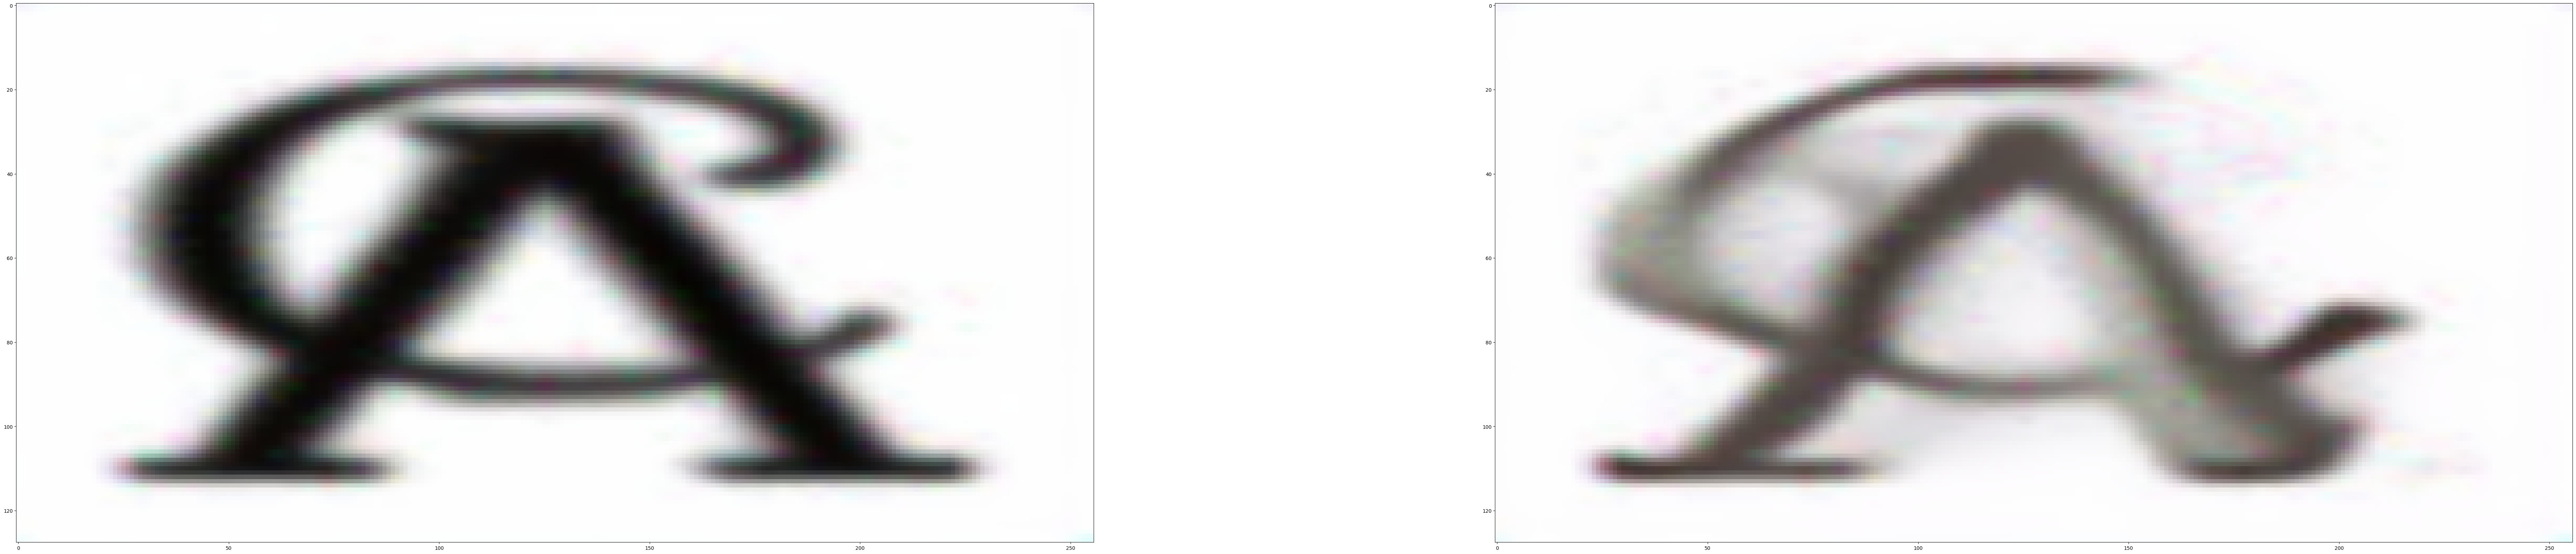

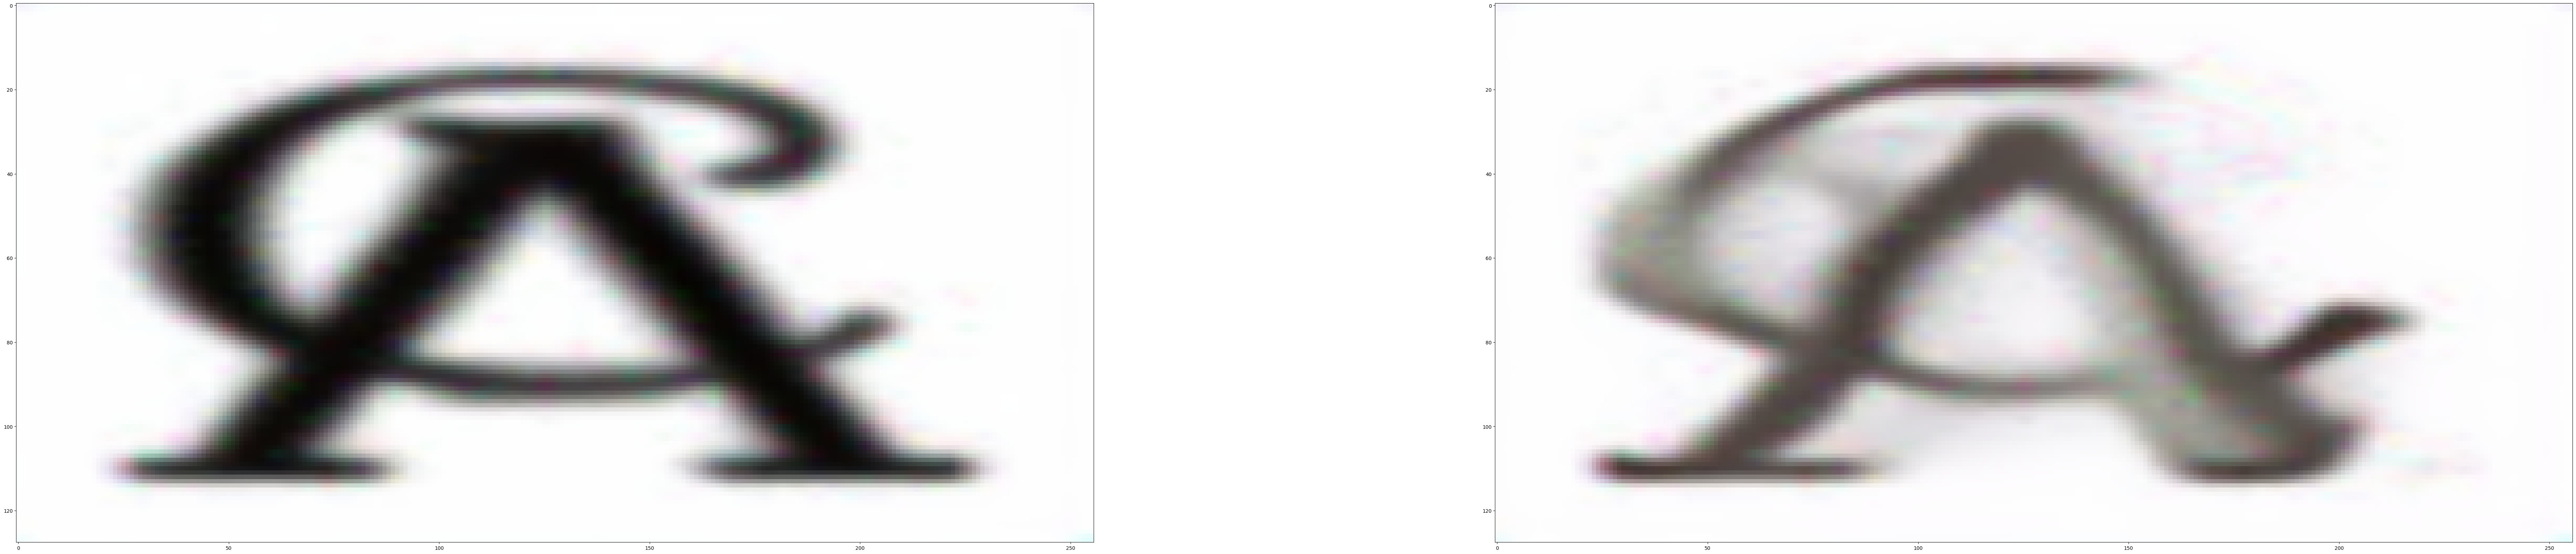

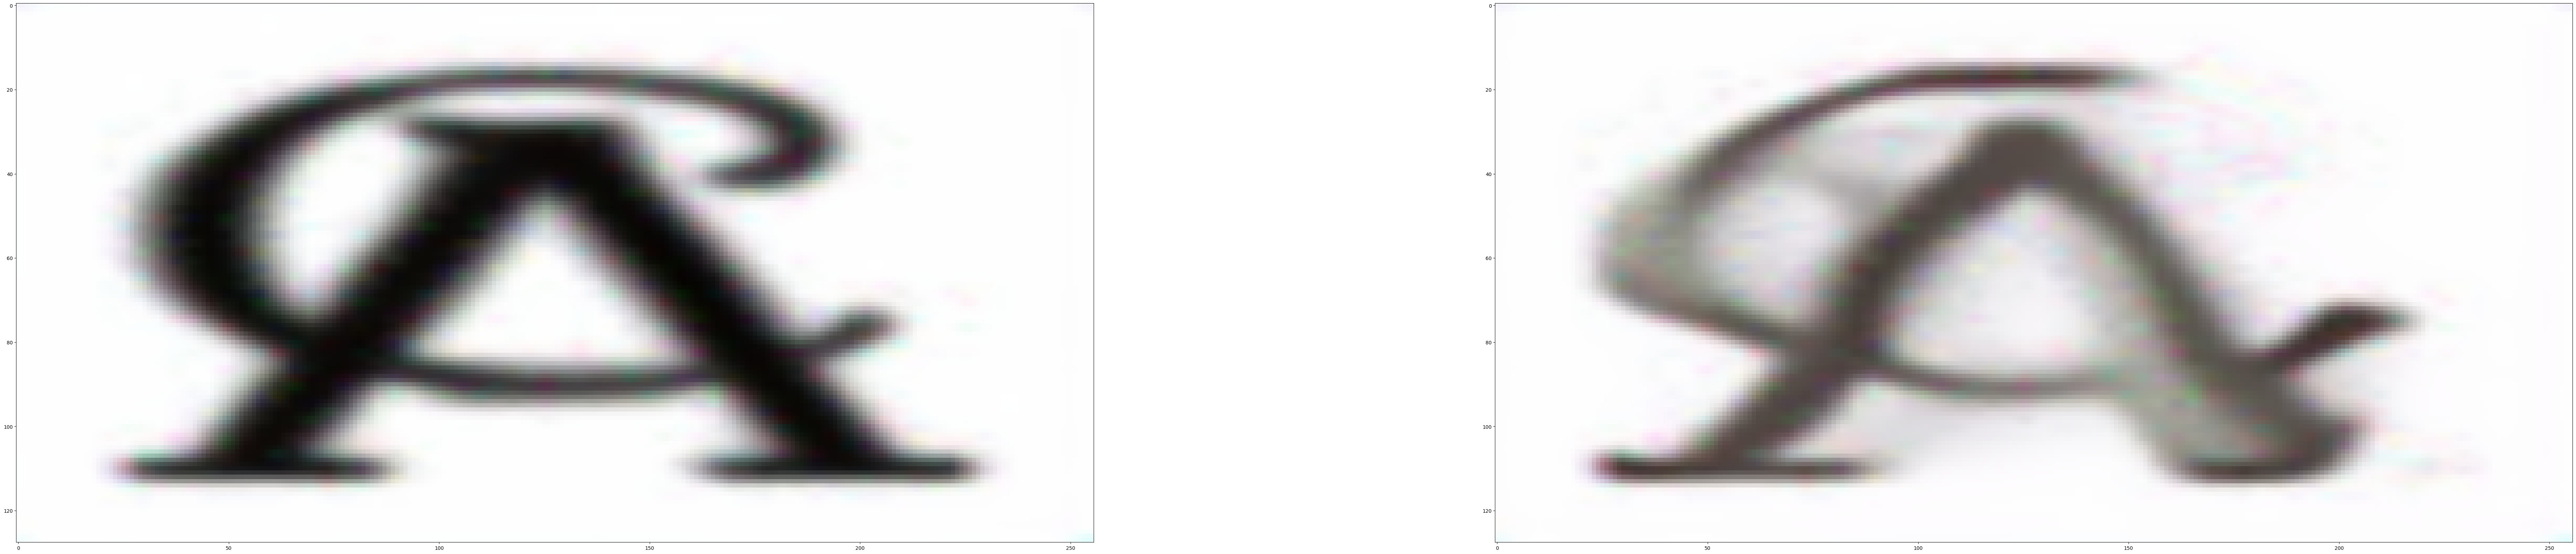

In [21]:

vis_num_pc = 5
vis_num_pc_list = list(range(vis_num_pc))
for pc_idx in vis_num_pc_list:
    # parallel transport sample (sample_idx_0 -> sample_idx_1)
    vk_list = []
    for direction in [1, -1]:        
        # edit latent variable
        vk = direction*vT_1.T @ (u_1.T @ u_0[:, pc_idx])
        vk = vk / vk.norm()
        vk = vk.view(-1, *original_xt_0.shape[1:]).to(device)
        vk_list.append(vk.clone())
        xt_list = [original_xt_1.clone()]
        
        # if x_space_guidance

        # for _ in tqdm(range(10), desc='x_space_guidance edit'):
        #     xt_edit = x_space_guidance(
        #         xt_list[-1], t_idx=50, vk=vk, 
        #         single_edit_step=1,
        #     )
        #     xt_list.append(xt_edit)
            
        # xt = torch.cat(xt_list, dim=0)
        # xt = xt[::int(xt.size(0) / vis_num)]
        # xt = xt_list[0]
        
        xt = xT_1 + vk # add style vector to stochstic code
        xt_0 = model.render(xT_1, cond_0, T=10) # denoise
        resize_transform = transforms.Resize((128, 256))
        pred = [resize_transform(image) for image in [original_xt_1, xt_0]]
        torch.manual_seed(1)
        fig, ax = plt.subplots(1, 2, figsize=(10*10, 20))
        for i in range(2):
            ax[i].imshow(pred[i][0].permute(1, 2, 0).cpu())
                
        
    # save vk
    try:
        tvu.save_image(
            torch.cat(vk_list, dim=0), f'pc_{pc_idx:0=3d}.png'
        )
    except Exception as e:
        print(e)
        pass